In [172]:
# Foundation
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pickle

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, \
                            confusion_matrix, classification_report, roc_auc_score, \
                            roc_curve, auc, precision_recall_curve, average_precision_score

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

from transformers import BertForSequenceClassification, BertTokenizer, \
                         Trainer, TrainingArguments, DistilBertTokenizerFast, \
                         DistilBertForSequenceClassification, pipeline

from datasets import load_metric

import os
os.environ["IOPUB_DATA_RATE_LIMIT"] = "2000000000"

from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
from functools import partial
import cProfile

In [2]:
# Set the display options
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.expand_frame_repr", False)  # Prevent wrapping to multiple lines

### Load Data, Concatenate and Explore

In [3]:
file1 = pd.read_csv("../data/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv")
file2 = pd.read_csv("../data/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv")
file3 = pd.read_csv("../data/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
file4 = pd.read_csv("../data/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
file5 = pd.read_csv("../data/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv")
file6 = pd.read_csv("../data/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv")
file7 = pd.read_csv("../data/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
file8 = pd.read_csv("../data/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")

In [113]:
df = pd.concat([file1, file2, file3, file4, file5, file6, file7, file8], ignore_index=True)

In [114]:
df.shape

(2830743, 79)

In [115]:
print(df.dtypes)

 Destination Port                 int64
 Flow Duration                    int64
 Total Fwd Packets                int64
 Total Backward Packets           int64
Total Length of Fwd Packets       int64
 Total Length of Bwd Packets      int64
 Fwd Packet Length Max            int64
 Fwd Packet Length Min            int64
 Fwd Packet Length Mean         float64
 Fwd Packet Length Std          float64
Bwd Packet Length Max             int64
 Bwd Packet Length Min            int64
 Bwd Packet Length Mean         float64
 Bwd Packet Length Std          float64
Flow Bytes/s                    float64
 Flow Packets/s                 float64
 Flow IAT Mean                  float64
 Flow IAT Std                   float64
 Flow IAT Max                     int64
 Flow IAT Min                     int64
Fwd IAT Total                     int64
 Fwd IAT Mean                   float64
 Fwd IAT Std                    float64
 Fwd IAT Max                      int64
 Fwd IAT Min                      int64


In [116]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.00,0.00,6,6,6.00,0.00,313.25,52.21,38308.00,0.00,38308,38308,0,0.00,0.00,0,0,0,0.00,0.00,0,0,0,0,0,0,20,20,26.10,26.10,6,6,6.00,0.00,0.00,0,0,0,0,1,1,0,0,1,9.00,6.00,6.00,20,0,0,0,0,0,0,1,6,1,6,255,946,0,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.64,31.45,163,0,65.20,89.28,1039665.97,33402.92,31.93,25.51,73,0,479,47.90,38.94,109,1,401,100.25,101.74,237,3,0,0,0,0,368,176,22964.51,10438.41,0,163,29.29,56.53,3195.60,0,0,0,1,0,0,0,0,0,31.12,15.64,65.20,368,0,0,0,0,0,0,11,172,5,326,29200,260,4,32,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
2,88,1095,10,6,3150,3150,1575,0,315.00,632.56,1575,0,525.00,813.33,5753424.66,14611.87,73.00,204.96,810,1,1095,121.67,298.75,915,1,995,199.00,345.54,810,3,0,0,0,0,336,208,9132.42,5479.45,0,1575,370.59,671.75,451250.13,0,0,0,1,0,0,0,0,0,393.75,315.00,525.00,336,0,0,0,0,0,0,10,3150,6,3150,29200,2081,3,32,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
3,389,15206,17,12,3452,6660,1313,0,203.06,425.78,3069,0,555.00,977.48,665000.66,1907.14,543.07,2519.93,13391,0,15206,950.38,3322.42,13391,2,15112,1373.82,4176.45,13961,3,0,0,0,0,560,388,1117.98,789.16,0,3069,337.07,704.65,496537.37,0,0,0,1,0,0,0,0,0,348.69,203.06,555.00,560,0,0,0,0,0,0,17,3452,12,6660,29200,0,10,32,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
4,88,1092,9,6,3150,3152,1575,0,350.00,694.51,1576,0,525.33,813.84,5771062.27,13736.26,78.00,207.00,794,1,1092,136.50,313.85,910,1,1015,203.00,333.24,794,3,0,0,0,0,304,208,8241.76,5494.51,0,1576,393.88,704.59,496440.12,0,0,0,1,0,0,0,0,0,420.13,350.00,525.33,304,0,0,0,0,0,0,9,3150,6,3152,29200,2081,2,32,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN


In [117]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

### Cleaning and Transformations

**Remove Leading Spaces from Column names**

In [118]:
df.columns = [col.strip() for col in df.columns]

**Replace Missing Values with 0, show before and after**

In [119]:
# Missing Values Before
missing_values_sum = df.isnull().sum()
missing_columns = missing_values_sum[missing_values_sum > 0]

if missing_columns.empty:
    print("No missing values in data")
else:
    print("Missing Values:")
    print(missing_columns)

# Fill missing values with 0
df.fillna(0, inplace=True)

# Missing Values After
missing_values_sum = df.isnull().sum()
missing_columns = missing_values_sum[missing_values_sum > 0]

if missing_columns.empty:
    print("No missing values in data")
else:
    print("Missing Values:")
    print(missing_columns)

Missing Values:
Flow Bytes/s    1358
dtype: int64
No missing values in data


**Check Columns that have Non-unique values and remove, show before and after**

In [120]:
# Check for unique values this will show columns that can be removed
# if a column has all 0's or all 1's then it has no impact on the model
print("Check Columns for unique values <= 1")
non_unique_columns = []
for column in df.columns:
    if df[column].nunique() <= 1:
        non_unique_columns.append(column)

print("Columns to be removed:", non_unique_columns)

# check 'Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 
# 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'
# To ensure that they have all 0s
cols = ['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 
        'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']

# Get the describe results for each specified column
results = [df[col].describe().round(2) for col in cols]

# Concatenate the results into a single DataFrame
result_df = pd.concat(results, axis=1)
result_df

Check Columns for unique values <= 1
Columns to be removed: ['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


,Bwd PSH Flags,Bwd URG Flags,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate
count,2830743.00,2830743.00,2830743.00,2830743.00,2830743.00,2830743.00,2830743.00,2830743.00
mean,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [128]:
print("columns before:")
print("column names:\n",df.columns, "\nShape:", df.shape)
df = df.drop(columns=non_unique_columns)
print("columns after drop:")
print("column names:\n",df.columns, "\nShape:", df.shape)

columns before:
column names:
 Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN F

**Explore "Label" column for invalid names**

In [129]:
df['Label'].unique()

array(['BENIGN', 'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk',
       'DoS GoldenEye', 'Heartbleed', 'FTP-Patator', 'SSH-Patator',
       'Infiltration', 'Web Attack Brute Force', 'Web Attack XSS',
       'Web Attack Sql Injection', 'Bot', 'PortScan', 'DDoS'],
      dtype=object)

In [130]:
df['Label'] = df['Label'].str.replace(' � ', ' ')

In [131]:
df['Label'].nunique()

15

In [132]:
df['Label'].unique()

array(['BENIGN', 'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk',
       'DoS GoldenEye', 'Heartbleed', 'FTP-Patator', 'SSH-Patator',
       'Infiltration', 'Web Attack Brute Force', 'Web Attack XSS',
       'Web Attack Sql Injection', 'Bot', 'PortScan', 'DDoS'],
      dtype=object)

**Check for infinity and Nan, replace with max value of data type**

In [133]:
inf_columns = df.iloc[:,:-1].columns[np.isinf(df.iloc[:,:-1]).any()]

# Identify columns with 'NaN' values
nan_columns = df.iloc[:,:-1].columns[df.iloc[:,:-1].isnull().any()]

print("inf:", inf_columns, "\nNan:", nan_columns)

inf: Index(['Flow Bytes/s', 'Flow Packets/s'], dtype='object') 
Nan: Index([], dtype='object')


In [134]:
# ## Long Runtime for this block
# # Find rows with 'inf' values
# inf_rows = df.iloc[:,:-1].applymap(np.isinf).any(axis=1)

# # Find rows with 'NaN' values
# nan_rows = df.iloc[:,:-1].applymap(np.isnan).any(axis=1)

In [135]:
# Replace code snippet above due to long run time, utilize multithreaded processing
# this is the first check to show values. This will be ran again to verify conversions
def check_inf(column, data):
    return data[column].apply(np.isinf)

def check_nan(column, data):
    return data[column].apply(np.isnan)

# using 24 cpu cores, adjust as necessary
with ThreadPoolExecutor(max_workers=24) as executor:
    check_inf_partial = partial(check_inf, data=df.iloc[:, :-1])
    inf_columns = list(executor.map(check_inf_partial, df.iloc[:, :-1].columns))
    
    check_nan_partial = partial(check_nan, data=df.iloc[:, :-1])
    nan_columns = list(executor.map(check_nan_partial, df.iloc[:, :-1].columns))

inf_rows = pd.concat(inf_columns, axis=1).any(axis=1)
nan_rows = pd.concat(nan_columns, axis=1).any(axis=1)



# 2867 rows that have inf/nan
df.loc[inf_rows].shape

(2867, 71)

In [136]:
df.loc[nan_rows].shape

(0, 71)

In [137]:
df.loc[inf_rows,['Flow Bytes/s', 'Flow Packets/s', 'Label']]

,Flow Bytes/s,Flow Packets/s,Label
1392,inf,inf,BENIGN
2041,inf,inf,BENIGN
2395,inf,inf,BENIGN
3097,inf,inf,BENIGN
3789,inf,inf,BENIGN
4301,inf,inf,BENIGN
4939,inf,inf,BENIGN
5106,0.00,inf,BENIGN
5833,0.00,inf,BENIGN
6553,inf,inf,BENIGN


In [138]:
for column in ['Flow Bytes/s', 'Flow Packets/s']:
    finite_max = df[df[column] != np.inf][column].max()
    df[column] = df[column].replace(np.inf, finite_max)

In [23]:
# ## Long Runtime for this block
# # Find rows with 'inf' values
# inf_rows = df.iloc[:,:-1].applymap(np.isinf).any(axis=1)

# # Find rows with 'NaN' values
# nan_rows = df.iloc[:,:-1].applymap(np.isnan).any(axis=1)

# # combine rows
# inf_nan_rows = inf_rows | nan_rows

# # 0 rows that hvae inf or nan after
# df.loc[inf_nan_rows].shape

In [139]:
# Same code as ran previously to check that rows were transformed
with ThreadPoolExecutor(max_workers=24) as executor:
    check_inf_partial = partial(check_inf, data=df.iloc[:, :-1])
    inf_columns = list(executor.map(check_inf_partial, df.iloc[:, :-1].columns))
    
    check_nan_partial = partial(check_nan, data=df.iloc[:, :-1])
    nan_columns = list(executor.map(check_nan_partial, df.iloc[:, :-1].columns))

inf_rows = pd.concat(inf_columns, axis=1).any(axis=1)
nan_rows = pd.concat(nan_columns, axis=1).any(axis=1)

# 0 rows that hvae inf or nan after
df.loc[inf_rows].shape

(0, 71)

**Summary Stats, Verify that data is cleaned. Multithreaded for speed**

In [141]:
def stats(df, column):
    count = df[column].count()
    mean = df[column].mean()
    std = df[column].std()
    min_value = df[column].min()
    max_value = df[column].max()
    return column, (count, mean, std, min_value, max_value)

def wrapped_stats(column):
    return stats(df.iloc[:, :-1], column)

# Use ThreadPoolExecutor for parallelization
with ThreadPoolExecutor() as executor:
    columns_to_process = df.columns[:-1]
    results = list(tqdm(executor.map(wrapped_stats, columns_to_process), total=len(columns_to_process), desc='Computing stats'))

# Process the results and create a DataFrame
stats_df = pd.DataFrame({column: values for column, values in results}, index=['count', 'mean', 'std', 'min', 'max'])

# Transpose the DataFrame and format the output
pd.options.display.float_format = "{:.2f}".format
stats_df.T


Computing stats:   0%|          | 0/70 [00:01<?, ?it/s]

,count,mean,std,min,max
Destination Port,2830743.00,8071.48,18283.63,0.00,65535.00
Flow Duration,2830743.00,14785663.93,33653744.09,-13.00,119999998.00
Total Fwd Packets,2830743.00,9.36,749.67,1.00,219759.00
Total Backward Packets,2830743.00,10.39,997.39,0.00,291922.00
Total Length of Fwd Packets,2830743.00,549.30,9993.59,0.00,12900000.00
Total Length of Bwd Packets,2830743.00,16162.64,2263088.05,0.00,655453030.00
Fwd Packet Length Max,2830743.00,207.60,717.18,0.00,24820.00
Fwd Packet Length Min,2830743.00,18.71,60.34,0.00,2325.00
Fwd Packet Length Mean,2830743.00,58.20,186.09,0.00,5940.86
Fwd Packet Length Std,2830743.00,68.91,281.19,0.00,7125.60


In [142]:
# Columns that have negative values
value_columns = ['Flow Duration', 'Flow Bytes/s','Flow Packets/s',
                 'Flow IAT Min','Fwd Header Length','Bwd Header Length',
                 'Fwd Header Length.1','min_seg_size_forward',
                 'Init_Win_bytes_forward','Init_Win_bytes_backward']

negative_counts = {}
# Iterate through the unique labels
for label in df['Label'].unique():
    label_df = df[df['Label'] == label]
    negative_counts[label] = {}
    for column in df[value_columns]:
        negative_count = (label_df[column] < 0).sum()
        negative_counts[label][column] = negative_count

# Convert dictionary to a DataFrame
negative_counts_df = pd.DataFrame(negative_counts).T
negative_counts_df

,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Min,Fwd Header Length,Bwd Header Length,Fwd Header Length.1,min_seg_size_forward,Init_Win_bytes_forward,Init_Win_bytes_backward
BENIGN,115,85,115,2697,35,22,35,35,1001182,1318981
DoS slowloris,0,0,0,0,0,0,0,0,0,1642
DoS Slowhttptest,0,0,0,0,0,0,0,0,0,3172
DoS Hulk,0,0,0,159,0,0,0,0,0,67060
DoS GoldenEye,0,0,0,5,0,0,0,0,0,2579
Heartbleed,0,0,0,4,0,0,0,0,0,0
FTP-Patator,0,0,0,4,0,0,0,0,0,1494
SSH-Patator,0,0,0,2,0,0,0,0,0,12
Infiltration,0,0,0,1,0,0,0,0,0,3
Web Attack Brute Force,0,0,0,0,0,0,0,0,0,0


In [ ]:
# def plot_negative_histogram(value_column, label):
#     filtered_df = df[df['Label'] == label]
#     negative_values = filtered_df[filtered_df[value_column] < 0][value_column]
    
#     # Check if there are any negative values
#     if not negative_values.empty:
#         plt.hist(negative_values, bins=20, edgecolor='k')
#         plt.xlabel(value_column)
#         plt.ylabel('Frequency')
#         plt.title(f'Histogram of Negative Values for {value_column} in {label}')
#         plt.show()

# # same as before just showing again
# value_columns = ['Flow Duration', 'Flow Bytes/s','Flow Packets/s',
#                  'Flow IAT Min','Fwd Header Length','Bwd Header Length',
#                  'Fwd Header Length.1','min_seg_size_forward',
#                  'Init_Win_bytes_forward','Init_Win_bytes_backward']

# # Loop through columns and malware labels
# for col in value_columns:
#     #print(20*"*",col)
#     for malware in df['Label'].unique():
#        #print(malware)
#         plot_negative_histogram(col, malware)

**Median Imputation for Negative Values**

In [143]:
# Median imputation
df_median = df.copy()
print("copy complete")

def wrapped_stats_median(column):
    return stats(df_median.iloc[:, :-1], column)

for column in df_median.iloc[:, :-1].columns:
    median_value = df_median[column][df_median[column] > 0].median()
    df_median.loc[df[column] < 0, column] = median_value

df_median.to_pickle('../data/capstone_cleaned_median.pkl')

# Use ThreadPoolExecutor for parallelization
with ThreadPoolExecutor() as executor:
    columns_to_process = df_median.columns[:-1] 
    results = list(tqdm(executor.map(wrapped_stats_median, columns_to_process), total=len(columns_to_process), desc='Computing stats'))

# Process the results and create a DataFrame
median_stats_df = pd.DataFrame({column: values for column, values in results}, index=['count', 'mean', 'std', 'min', 'max'])

# Transpose the DataFrame and format the output
pd.options.display.float_format = "{:.2f}".format
median_stats_df.T


copy complete


Computing stats:   0%|          | 0/70 [00:00<?, ?it/s]

,count,mean,std,min,max
Destination Port,2830743.00,8071.48,18283.63,0.00,65535.00
Flow Duration,2830743.00,14785665.20,33653743.53,0.00,119999998.00
Total Fwd Packets,2830743.00,9.36,749.67,1.00,219759.00
Total Backward Packets,2830743.00,10.39,997.39,0.00,291922.00
Total Length of Fwd Packets,2830743.00,549.30,9993.59,0.00,12900000.00
Total Length of Bwd Packets,2830743.00,16162.64,2263088.05,0.00,655453030.00
Fwd Packet Length Max,2830743.00,207.60,717.18,0.00,24820.00
Fwd Packet Length Min,2830743.00,18.71,60.34,0.00,2325.00
Fwd Packet Length Mean,2830743.00,58.20,186.09,0.00,5940.86
Fwd Packet Length Std,2830743.00,68.91,281.19,0.00,7125.60


**Mean Imputation for Negative Values**

In [144]:
df_mean = df.copy()

def wrapped_stats_mean(column):
    return stats(df_mean.iloc[:, :-1], column)

for column in df_mean.iloc[:, :-1].columns:
    mean_value = df_mean[column][df_mean[column] > 0].mean()
    df_mean.loc[df_mean[column] < 0, column] = mean_value
    
# Data to Computer for Modeling script
df_mean.to_pickle('../data/capstone_cleaned_mean.pkl')

# Check for negative values utilizing multi-threading
with ThreadPoolExecutor() as executor:
    columns_to_process = df_mean.columns[:-1]
    # tqdm is the progress bar
    results = list(tqdm(executor.map(wrapped_stats_mean, columns_to_process), total=len(columns_to_process), desc='Computing stats'))

# Process the results and create a DataFrame
mean_stats_df = pd.DataFrame({column: values for column, values in results}, index=['count', 'mean', 'std', 'min', 'max'])

# Transpose the DataFrame and format the output
pd.options.display.float_format = "{:.2f}".format
mean_stats_df.T


Computing stats:   0%|          | 0/70 [00:00<?, ?it/s]

,count,mean,std,min,max
Destination Port,2830743.00,8071.48,18283.63,0.00,65535.00
Flow Duration,2830743.00,14786265.24,33653612.13,0.00,119999998.00
Total Fwd Packets,2830743.00,9.36,749.67,1.00,219759.00
Total Backward Packets,2830743.00,10.39,997.39,0.00,291922.00
Total Length of Fwd Packets,2830743.00,549.30,9993.59,0.00,12900000.00
Total Length of Bwd Packets,2830743.00,16162.64,2263088.05,0.00,655453030.00
Fwd Packet Length Max,2830743.00,207.60,717.18,0.00,24820.00
Fwd Packet Length Min,2830743.00,18.71,60.34,0.00,2325.00
Fwd Packet Length Mean,2830743.00,58.20,186.09,0.00,5940.86
Fwd Packet Length Std,2830743.00,68.91,281.19,0.00,7125.60


**Negative Values to 0**

In [146]:
df_zero = df.copy()

def wrapped_stats_zero(column):
    return stats(df_zero.iloc[:, :-1], column)

# Excluding Label, turn all neg values to 0
for column in df.iloc[:, :-1].columns:
    df_zero.loc[df_zero[column] < 0, column] = 0
    
df_zero.to_pickle('../data/capstone_cleaned_zero.pkl')

# Use ThreadPoolExecutor for parallelization to get summary stats
with ThreadPoolExecutor() as executor:
    columns_to_process = df_zero.columns[:-1]
    results = list(tqdm(executor.map(wrapped_stats_zero, columns_to_process), total=len(columns_to_process), desc='Computing stats'))

# Process the results and create a DataFrame
stats_df_zero = pd.DataFrame({column: values for column, values in results}, index=['count', 'mean', 'std', 'min', 'max'])

# Transpose the DataFrame and format the output
pd.options.display.float_format = "{:.2f}".format
stats_df_zero.T

Computing stats:   0%|          | 0/70 [00:01<?, ?it/s]

,count,mean,std,min,max
Destination Port,2830743.00,8071.48,18283.63,0.00,65535.00
Flow Duration,2830743.00,14785663.93,33653744.09,0.00,119999998.00
Total Fwd Packets,2830743.00,9.36,749.67,1.00,219759.00
Total Backward Packets,2830743.00,10.39,997.39,0.00,291922.00
Total Length of Fwd Packets,2830743.00,549.30,9993.59,0.00,12900000.00
Total Length of Bwd Packets,2830743.00,16162.64,2263088.05,0.00,655453030.00
Fwd Packet Length Max,2830743.00,207.60,717.18,0.00,24820.00
Fwd Packet Length Min,2830743.00,18.71,60.34,0.00,2325.00
Fwd Packet Length Mean,2830743.00,58.20,186.09,0.00,5940.86
Fwd Packet Length Std,2830743.00,68.91,281.19,0.00,7125.60


### Correlation of Labels to features

One-hot lableing so that each Label turned into column and the label under analysis remains while the rest of the labels are dropped

In [31]:
# Convert Lables to one-hot
one_hot = pd.get_dummies(df['Label'])

In [32]:
one_hot.head()

,BENIGN,Bot,DDoS,DoS GoldenEye,DoS Hulk,DoS Slowhttptest,DoS slowloris,FTP-Patator,Heartbleed,Infiltration,PortScan,SSH-Patator,Web Attack Brute Force,Web Attack Sql Injection,Web Attack XSS
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
one_hot.shape

(2830743, 15)

In [34]:
df_no_label = df.drop('Label', axis=1)

In [35]:
df_no_label.head(3)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,80,38308,1,1,6,6,6,6,6.00,0.00,6,6,6.00,0.00,313.25,52.21,38308.00,0.00,38308,38308,0,0.00,0.00,0,0,0,0.00,0.00,0,0,0,0,20,20,26.10,26.10,6,6,6.00,0.00,0.00,0,0,0,0,1,1,0,0,1,9.00,6.00,6.00,20,1,6,1,6,255,946,0,20,0.00,0.00,0,0,0.00,0.00,0,0
1,389,479,11,5,172,326,79,0,15.64,31.45,163,0,65.20,89.28,1039665.97,33402.92,31.93,25.51,73,0,479,47.90,38.94,109,1,401,100.25,101.74,237,3,0,0,368,176,22964.51,10438.41,0,163,29.29,56.53,3195.60,0,0,0,1,0,0,0,0,0,31.12,15.64,65.20,368,11,172,5,326,29200,260,4,32,0.00,0.00,0,0,0.00,0.00,0,0
2,88,1095,10,6,3150,3150,1575,0,315.00,632.56,1575,0,525.00,813.33,5753424.66,14611.87,73.00,204.96,810,1,1095,121.67,298.75,915,1,995,199.00,345.54,810,3,0,0,336,208,9132.42,5479.45,0,1575,370.59,671.75,451250.13,0,0,0,1,0,0,0,0,0,393.75,315.00,525.00,336,10,3150,6,3150,29200,2081,3,32,0.00,0.00,0,0,0.00,0.00,0,0


In [36]:
# List Columns for correct spelling
one_hot.columns

Index(['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk',
       'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Heartbleed',
       'Infiltration', 'PortScan', 'SSH-Patator', 'Web Attack Brute Force',
       'Web Attack Sql Injection', 'Web Attack XSS'],
      dtype='object')

### Correlation of 15 Malware Labels to rest of Dataset Features

In [37]:
def correlation(one_hot_df, target, df_no_label):
    columns_to_drop = ['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 
                       'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Heartbleed',
                       'Infiltration', 'PortScan', 'SSH-Patator', 'Web Attack Brute Force',
                       'Web Attack Sql Injection', 'Web Attack XSS']

    columns_to_drop.remove(target)

    target_df = one_hot_df.drop(columns=columns_to_drop)
    df_func = pd.concat([target_df, df_no_label], axis=1)
    cor = df_func.corr().round(3)
    cor.sort_values([target], ascending=False, inplace=True)
    return cor[target]

In [38]:
BENIGN = correlation(one_hot, 'BENIGN', df_no_label)

In [39]:
Bot = correlation(one_hot, 'Bot', df_no_label)

In [40]:
DDoS = correlation(one_hot, 'DDoS', df_no_label)

In [41]:
DoS_GoldenEye = correlation(one_hot, 'DoS GoldenEye', df_no_label)

In [42]:
DoS_Hulk = correlation(one_hot, 'DoS Hulk', df_no_label)

In [43]:
DoS_Slowhttptest = correlation(one_hot, 'DoS Slowhttptest', df_no_label)

In [44]:
DoS_slowloris = correlation(one_hot, 'DoS slowloris', df_no_label)

In [45]:
FTP_Patator = correlation(one_hot, 'FTP-Patator', df_no_label)

In [46]:
Heartbleed = correlation(one_hot, 'Heartbleed', df_no_label)

In [47]:
Infiltration = correlation(one_hot, 'Infiltration', df_no_label)

In [48]:
PortScan = correlation(one_hot, 'PortScan', df_no_label)

In [49]:
SSH_Patator = correlation(one_hot, 'SSH-Patator', df_no_label)

In [50]:
Web_Attack_Brute_Force = correlation(one_hot, 'Web Attack Brute Force', df_no_label)

In [51]:
Web_Attack_Sql_Injection = correlation(one_hot, 'Web Attack Sql Injection', df_no_label)

In [52]:
Web_Attack_XSS = correlation(one_hot, 'Web Attack XSS', df_no_label)

In [53]:
corr_df = pd.concat([BENIGN[1:], Bot[1:], DDoS[1:], DoS_GoldenEye[1:], DoS_Hulk[1:], 
                     DoS_Slowhttptest[1:], DoS_slowloris[1:], FTP_Patator[1:], 
                     Heartbleed[1:], Infiltration[1:], PortScan[1:], SSH_Patator[1:], 
                     Web_Attack_Brute_Force[1:], Web_Attack_Sql_Injection[1:], 
                     Web_Attack_XSS[1:]  ], axis=1)
corr_df              

,BENIGN,Bot,DDoS,DoS GoldenEye,DoS Hulk,DoS Slowhttptest,DoS slowloris,FTP-Patator,Heartbleed,Infiltration,PortScan,SSH-Patator,Web Attack Brute Force,Web Attack Sql Injection,Web Attack XSS
Min Packet Length,0.30,-0.01,-0.12,-0.04,-0.19,0.01,-0.03,-0.04,-0.00,-0.00,-0.15,-0.03,-0.01,-0.00,-0.01
Bwd Packet Length Min,0.28,-0.01,-0.13,-0.04,-0.18,-0.03,-0.03,-0.03,-0.00,-0.00,-0.12,-0.03,-0.01,-0.00,-0.01
Destination Port,0.15,0.01,-0.10,-0.03,-0.13,-0.02,-0.02,-0.02,-0.00,-0.00,0.01,-0.02,-0.01,-0.00,-0.01
URG Flag Count,0.15,0.02,-0.07,-0.02,-0.10,0.00,-0.01,-0.02,-0.00,-0.00,-0.08,0.06,0.00,0.00,-0.00
Fwd Packet Length Min,0.14,-0.01,-0.06,-0.02,-0.09,0.07,-0.01,-0.02,-0.00,-0.00,-0.07,-0.01,-0.01,-0.00,-0.01
Init_Win_bytes_backward,0.10,-0.00,-0.05,-0.01,-0.06,-0.00,-0.01,-0.01,-0.00,-0.00,-0.05,-0.01,0.06,-0.00,0.04
Avg Fwd Segment Size,0.09,0.01,-0.06,0.00,-0.02,0.02,0.00,-0.01,-0.00,0.01,-0.07,-0.00,-0.01,0.00,-0.00
Fwd Packet Length Mean,0.09,0.01,-0.06,0.00,-0.02,0.02,0.00,-0.01,-0.00,0.01,-0.07,-0.00,-0.01,0.00,-0.00
Fwd PSH Flags,0.08,-0.01,-0.05,-0.01,-0.07,0.02,0.06,0.11,-0.00,0.01,-0.05,-0.01,-0.01,-0.00,-0.00
SYN Flag Count,0.08,-0.01,-0.05,-0.01,-0.07,0.02,0.06,0.11,-0.00,0.01,-0.05,-0.01,-0.01,-0.00,-0.00


#### Find the max token length of the CICIDS2017

In [54]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [55]:
observation = df.iloc[0,:-1].tolist() # -1, not tokenizing the label
observation

[80,
 38308,
 1,
 1,
 6,
 6,
 6,
 6,
 6.0,
 0.0,
 6,
 6,
 6.0,
 0.0,
 313.250496,
 52.208416,
 38308.0,
 0.0,
 38308,
 38308,
 0,
 0.0,
 0.0,
 0,
 0,
 0,
 0.0,
 0.0,
 0,
 0,
 0,
 0,
 20,
 20,
 26.104208,
 26.104208,
 6,
 6,
 6.0,
 0.0,
 0.0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 9.0,
 6.0,
 6.0,
 20,
 1,
 6,
 1,
 6,
 255,
 946,
 0,
 20,
 0.0,
 0.0,
 0,
 0,
 0.0,
 0.0,
 0,
 0]

In [56]:
feature_string = ' '.join([str(f) for f in observation])
print(feature_string,", string length:",len(feature_string))

80 38308 1 1 6 6 6 6 6.0 0.0 6 6 6.0 0.0 313.250496 52.208416 38308.0 0.0 38308 38308 0 0.0 0.0 0 0 0 0.0 0.0 0 0 0 0 20 20 26.104208 26.104208 6 6 6.0 0.0 0.0 0 0 0 0 1 1 0 0 1 9.0 6.0 6.0 20 1 6 1 6 255 946 0 20 0.0 0.0 0 0 0.0 0.0 0 0 , string length: 237


In [57]:
tokenized_observation = tokenizer(feature_string, return_tensors='pt',
                                  max_length=256, padding='max_length',
                                  truncation=True,
                                 )
tokenized_observation['input_ids']

tensor([[  101,  3770,  4229, 14142,  2620,  1015,  1015,  1020,  1020,  1020,
          1020,  1020,  1012,  1014,  1014,  1012,  1014,  1020,  1020,  1020,
          1012,  1014,  1014,  1012,  1014, 22997,  1012,  5539, 26224,  2575,
          4720,  1012, 18512, 23632,  2575,  4229, 14142,  2620,  1012,  1014,
          1014,  1012,  1014,  4229, 14142,  2620,  4229, 14142,  2620,  1014,
          1014,  1012,  1014,  1014,  1012,  1014,  1014,  1014,  1014,  1014,
          1012,  1014,  1014,  1012,  1014,  1014,  1014,  1014,  1014,  2322,
          2322,  2656,  1012,  9645, 11387,  2620,  2656,  1012,  9645, 11387,
          2620,  1020,  1020,  1020,  1012,  1014,  1014,  1012,  1014,  1014,
          1012,  1014,  1014,  1014,  1014,  1014,  1015,  1015,  1014,  1014,
          1015,  1023,  1012,  1014,  1020,  1012,  1014,  1020,  1012,  1014,
          2322,  1015,  1020,  1015,  1020, 20637,  6365,  2575,  1014,  2322,
          1014,  1012,  1014,  1014,  1012,  1014,  

In [58]:
def row_tokenizer(row):
    row_text = ' '.join(str(value) for value in row)
    tokens = tokenizer(row_text, return_tensors='pt', padding=True)
    return tokens['input_ids'].size(1)

In [59]:
# Long run time
max_length = df.apply(row_tokenizer,axis=1).max()
print(max_length)

332


In [60]:
# Store Token lengths in list for analysis
token_lengths = df.apply(row_tokenizer, axis=1)

Text(0.5, 1.0, 'CICIDS2017 Token Lengths')

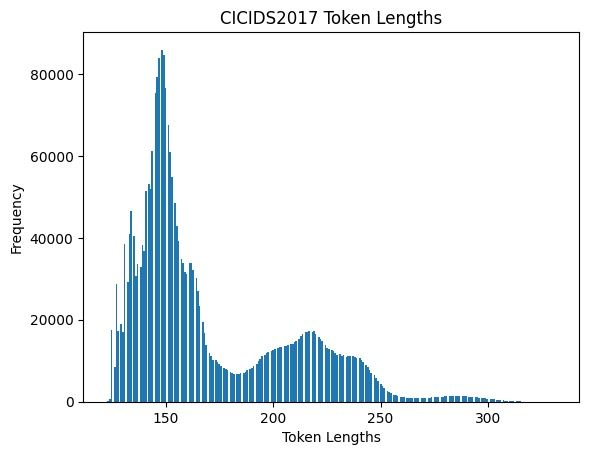

In [61]:
plt.hist(token_lengths, bins='auto')
plt.xlabel('Token Lengths')
plt.ylabel('Frequency')
plt.title('CICIDS2017 Token Lengths')

In [62]:
outlier_rows = df.loc[token_lengths > 512]
outlier_rows.shape
#outlier_rows.to_csv('outlier_rows') # file too large for jupiter books

(0, 71)

### Model Metrics and Performance

### Zero Imputation Model Metrics

In [152]:
# Had to create this function due to computer not able to handle full test set for inference
# Batch size can likely be set to 32 depending on GPU
def create_batches(tokenizer, features, labels, batch_size=16):
    encoded_inputs = tokenizer(features, padding=True, truncation=True, return_tensors="pt")
    dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'], torch.tensor(labels))
    dataloader = DataLoader(dataset, batch_size=batch_size)
    return dataloader

# Use GPU if available, print what device is being used
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load and preprocess the data, labels are already encoded
df = pd.read_pickle('../data/capstone_cleaned_zero.pkl')
print("Data Loaded")

# Train Test Split (Ensure seed matches python script)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
print("Train Test Split complete")

# Encode the labels
le = LabelEncoder()
train_data.iloc[:, -1] = le.fit_transform(train_data.iloc[:, -1])
test_data.iloc[:, -1] = le.transform(test_data.iloc[:, -1])
print("Labels Encoded")

# Load the model and tokenizer from the output directory
output_dir = "./zero_fine_tuned"
model = DistilBertForSequenceClassification.from_pretrained(output_dir).to(device)
tokenizer = DistilBertTokenizerFast.from_pretrained(output_dir)
print("Model Loaded and Tokenizer Loaded")

# Create a pipeline
nlp = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True, device=device)

# Evaluate the model on the test dataset
# Extract features and true labels from the test dataset
test_features = test_data.iloc[:, :-1].apply(lambda x: ' '.join(x.astype(str)), axis=1).tolist()
test_labels = test_data.iloc[:, -1].tolist()
print("Feature Extraction")

# Create the test_dataloader using the create_batches function
batch_size = 16
test_dataloader = create_batches(tokenizer, test_features, test_labels, batch_size=batch_size)
print("test dataloader")

# Get predictions from the model using batches
predictions = []
for batch in test_dataloader:
    input_ids, attention_mask, _ = batch
    batch_preds = model(input_ids.to(device), attention_mask.to(device)).logits
    batch_preds = batch_preds.detach().cpu().numpy()
    predictions.extend(batch_preds)

predicted_labels = [np.argmax(pred) for pred in predictions]


Using device: cuda
Data Loaded
Train Test Split complete


C:\Users\root\AppData\Local\Temp\ipykernel_10672\818026945.py:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_data.iloc[:, -1] = le.fit_transform(train_data.iloc[:, -1])
C:\Users\root\AppData\Local\Temp\ipykernel_10672\818026945.py:24: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_data.iloc[:, -1] = le.transform(test_data.iloc[:, -1])


Labels Encoded
Model Loaded and Tokenizer Loaded


C:\Users\root\Documents\projects\win-cpu\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Feature Extraction
test dataloader
Get predictions


In [153]:
# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted', zero_division=0)
acc = accuracy_score(test_labels, predicted_labels)
print("Calculate Metrics")

print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Calculate Metrics
Accuracy: 0.9989437409586522
Precision: 0.998879852123424
Recall: 0.9989437409586522
F1 Score: 0.998826355156612


In [154]:
with open("accuracy.pickle", "wb") as file:
    pickle.dump(acc, file)

with open("precision.pickle", "wb") as file:
    pickle.dump(precision, file)
    
with open("recall.pickle", "wb") as file:
    pickle.dump(recall, file)

with open("f1.pickle", "wb") as file:
    pickle.dump(f1, file)    

In [155]:
# Convert Encoded labels back to text labels for the confusion matrix
predicted_text_labels = le.inverse_transform(predicted_labels)
test_text_labels = le.inverse_transform(test_labels)

In [156]:
test_text_labels[:6]

array(['FTP-Patator', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN'],
      dtype=object)

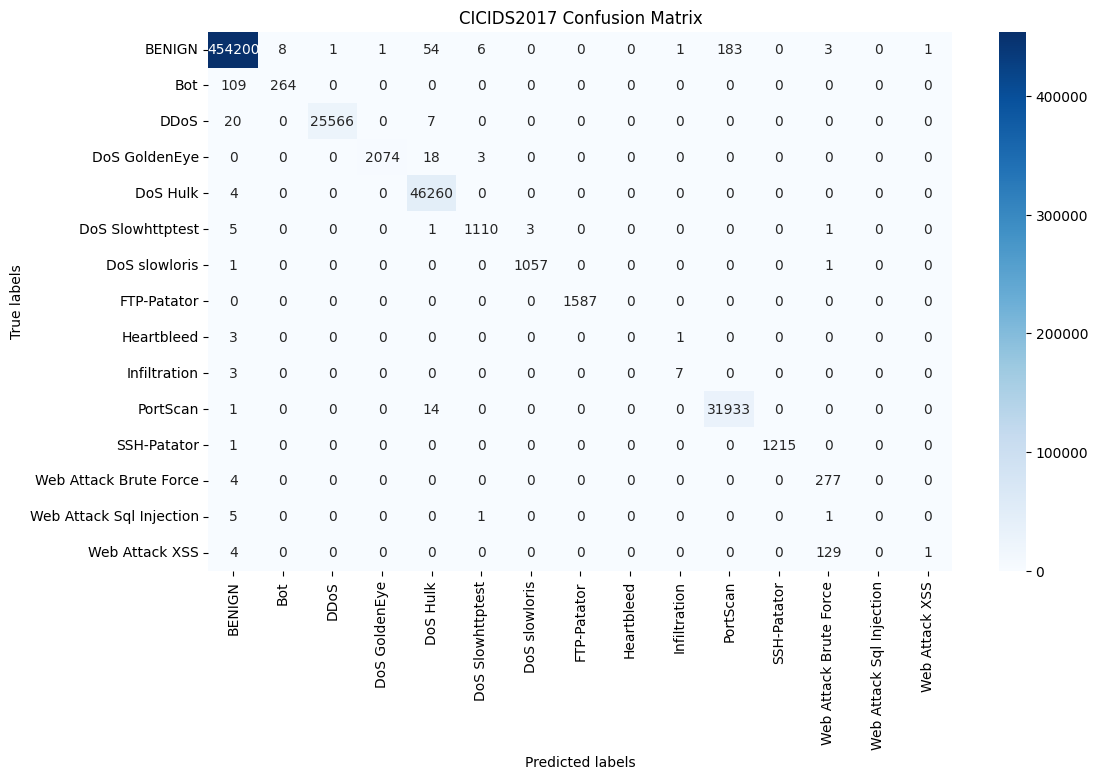

In [178]:
# Calculate confusion matrix
# cm = confusion_matrix(test_labels, predicted_labels)
cm = confusion_matrix(test_text_labels, predicted_text_labels, labels=le.classes_)
# Plot confusion matrix
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_, cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('CICIDS2017 Confusion Matrix')
plt.show()

with open("confusion.pickle", "wb") as file:
    pickle.dump(cm, file)

In [158]:
# Classification report
class_report = classification_report(
    test_labels, 
    predicted_labels, 
    target_names=le.classes_, 
    output_dict=True, 
    zero_division=0)

cr = pd.DataFrame(class_report).transpose()
cr.drop(columns=['support'], inplace=True)
cr['label'] = cr.index
cr.set_index('label', inplace=True)
cr.index.name = None
cr

,precision,recall,f1-score
BENIGN,1.00,1.00,1.00
Bot,0.97,0.71,0.82
DDoS,1.00,1.00,1.00
DoS GoldenEye,1.00,0.99,0.99
DoS Hulk,1.00,1.00,1.00
DoS Slowhttptest,0.99,0.99,0.99
DoS slowloris,1.00,1.00,1.00
FTP-Patator,1.00,1.00,1.00
Heartbleed,0.00,0.00,0.00
Infiltration,0.78,0.70,0.74


In [165]:
test_labels_bin = label_binarize(test_labels, classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



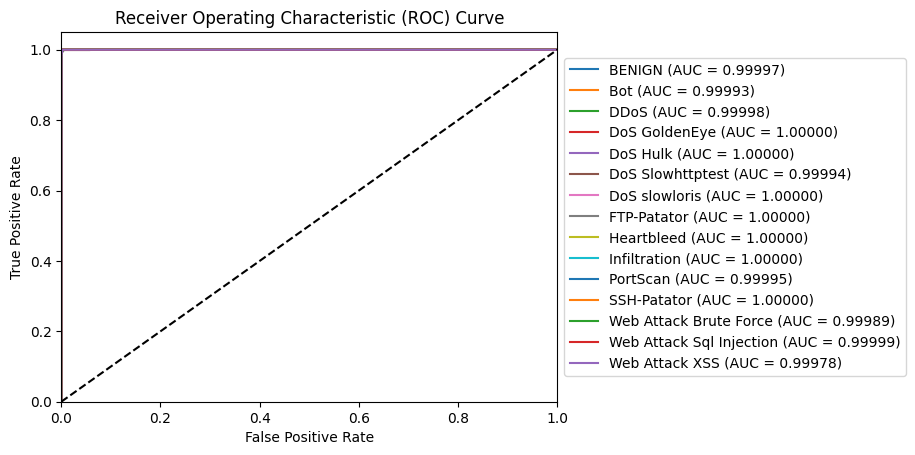

In [169]:
plt.figure()

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{le.inverse_transform([i])[0]} (AUC = {roc_auc[i]:.5f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Place the legend to the right of the plot area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


In [173]:
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(test_labels_bin[:, i], probs[:, i])
    average_precision[i] = average_precision_score(test_labels_bin[:, i], probs[:, i])


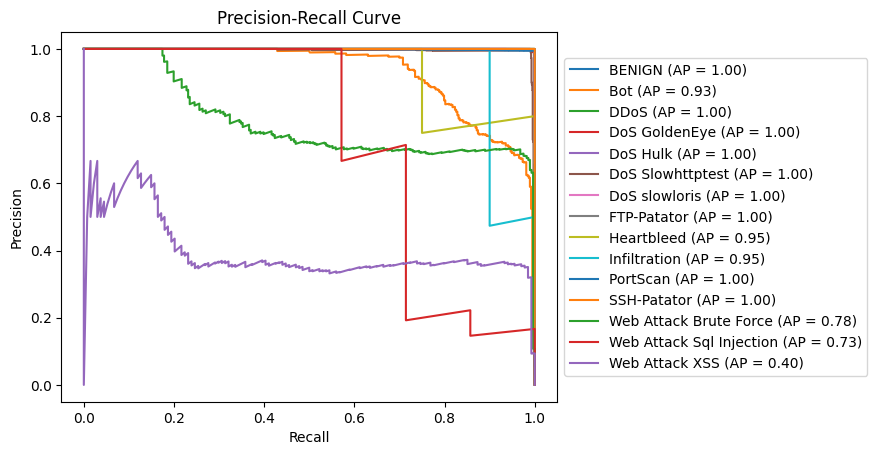

In [177]:
plt.figure()

for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'{le.inverse_transform([i])[0]} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()
